# NPZD_isotope model

### Adapted from Sarmiento and Gruber (2006) and Yoshikawa et al. (2005)
See attached model description for explanation

In [1]:
### Import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.dates as mdates
from scipy import *
from ipywidgets import interact, FloatSlider
from numba import jit

In [2]:
### Coefficients
h = 1 # times
nuto = .001 # initial condition for nutrient
phyo = .001 # initial condition for phyto
zooo = .001 # initial condition for zoo
deto = .001 # initial condition for detritus
# set parameters
Vmax = 1.0 # per day
K = 2 # mmol/m3
Kp= 2.8 # mmol/m3
Kammo=0.2
a = 0.7
b= 0.5
g = 1.4 # per day
lp = 0.05 # per day
lz = 0.05 # per day
ld = 0.05 # per day
Wsink=10 # m/day
c = .01 # 1/day, background mixing rate
#
h0 = 50 # m
h1 = 100 # m
#
I0 = 40 # W/m2
I1 = 150 # W/m2
#
zI = 20 #m
KI = 60 # W/m2
#
fPAR = .4
# Nutrient injection
Nth = 10
ammoth = 3.5
# Absolute value for 15N, 14N in deep water
Nth15 = 1.005 # d15NO3 = 5
Nth14 = 1
ammoth15= 1.012 # d15NH4 = 12
ammoth14 = 1

# Nitrification rate
nit = 0.15 

# Epsiolon for biological processes
eps_uptakeN= -5 # Phytoplankton NO3 uptake
eps_uptakeA= -10 # Phytoplankton NH4 uptake
eps_egestion= -1 # Zooplankton egestion
eps_excretion= -1 # Zooplankton excretion
eps_reminer= -1 # Remineralization
eps_nitri= -14 # Nitrification

In [3]:
### Evaluate seasonal cycle
%matplotlib inline
def seasonal_cycle(zI,h0,h1,I0,I1):
    t = np.arange(0,365*5,1)
    hml = h0+h1*(1+np.cos(2*np.pi/360*t))
    dhdt= -h1*(2*np.pi/360)*np.sin(2*np.pi/360*t)
    ent0=dhdt/hml
    ent=np.where(ent0>0,ent0,0) + c
    I=fPAR*(I0+I1*(1-np.cos(2*np.pi/360*t)))
    Iave=I*zI/hml
    #
    time = pd.to_datetime(t, unit = 'D',origin=pd.Timestamp("01-01-2020"))
    fig,ax=plt.subplots(2,2,figsize=(8, 8),sharex=True)
    ax[0,0].plot(time,-hml)
    ax[0,0].title.set_text('MLD')
    ax[0,1].plot(time,ent)
    ax[0,1].title.set_text('Entrainment')
    ax[1,0].plot(time,I)
    ax[1,0].title.set_text('I, surface')
    ax[1,1].plot(time,Iave)
    ax[1,1].title.set_text('I, average')
    xlim1 = pd.to_datetime(0, unit = 'D',origin=pd.Timestamp("01-01-2020"))
    xlim2 = pd.to_datetime(365, unit = 'D',origin=pd.Timestamp("01-01-2020"))
    plt.xlim(xlim1,xlim2)
    ax[1,1].xaxis.set_major_locator(mdates.MonthLocator())
    ax[1,1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    fig.tight_layout()

interact(seasonal_cycle,
         zI = FloatSlider(min=0, max=100, step =10, value=20),
         h0 = FloatSlider(min=0, max=1000, step =10, value=50),
         h1 = FloatSlider(min=0, max=1000, step =10, value=100),
         I0 = FloatSlider(min=0, max=300, step =10, value=40),
         I1 = FloatSlider(min=0, max=300, step =10, value=150),
        );
         

interactive(children=(FloatSlider(value=20.0, description='zI', step=10.0), FloatSlider(value=50.0, descriptio…

In [4]:
### Helper functions
# define model_run function
@jit
def model_run(trange,xinit,param,dt,tendency):
    Vmax,K,Kp,Kammo,a,b,g,lp,lz,ld,KI,Nth,ammoth,zI,Wsink,c,fPAR,nit,h0,h1,I0,I1 = param
    sol = solve_ivp(tendency,trange,xinit,args=(Vmax,K,Kp,Kammo,a,b,g,lp,lz,ld,KI,Nth,ammoth,zI,Wsink,c,fPAR,nit,h0,h1,I0,I1),method='RK45',max_step=dt)
    return sol

# Calulate alpha from epsilon
@jit
def alpha(eps):
    alpha = np.exp(eps/1000)
    return alpha

### NPZD model
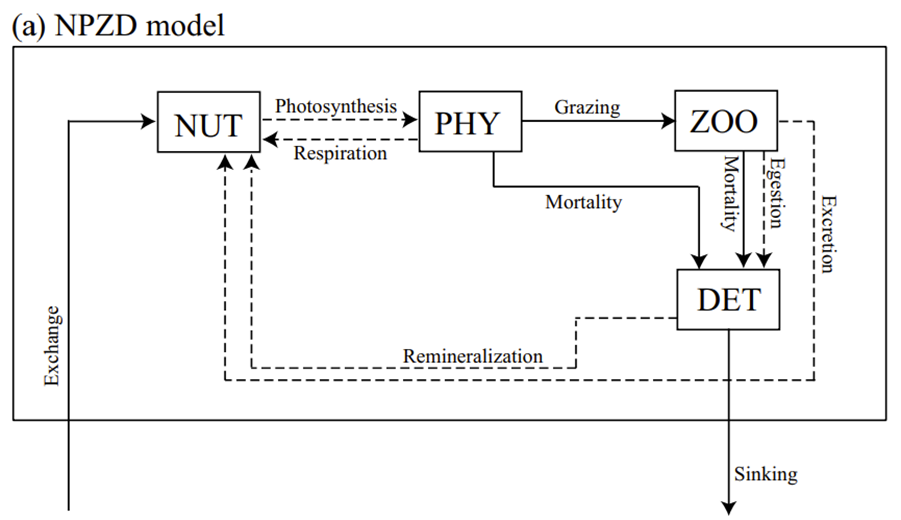


In [5]:
### NPZD function
# Compile python code to machine code to make it run faster
@jit
def NPZD(t,x,Vmax,K,Kp,Kammo,a,b,g,lp,lz,ld,KI,Nth,ammoth,zI,Wsink,c,fPAR,nit,h0,h1,I0,I1):
    # Import initial conditions
    nitro, phy, zoo, det, N15, P15, Z15, D15, N14, P14, Z14, D14 = x
    # Simulated parameters
    hml = h0+h1*(1+np.cos(2*np.pi/360*t))
    dhdt= -h1*(2*np.pi/360)*np.sin(2*np.pi/360*t)
    ent0=dhdt/hml
    ent=np.where(ent0>0,ent0,0) + c
    I=fPAR*(I0+I1*(1-np.cos(2*np.pi/360*t)))
    Iave=I*zI/hml
    # NPZD calculation
    dnitrodt = -Vmax*nitro/(nitro+K)*phy*Iave/(Iave+KI) -ent*(nitro-Nth) + ld*det + (a-b)*zoo*g*phy/Kp
    dphydt = Vmax*nitro/(nitro+K)*phy*Iave/(Iave+KI) - zoo*g*phy/Kp - (lp+ent)*phy
    dzoodt = a*zoo*g*phy/Kp - (lz+ent)*zoo - (a-b)*zoo*g*phy/Kp - (1-a)*zoo*g*phy/Kp
    ddetdt = (1-a)*zoo*g*phy/Kp + lz*zoo + lp*phy - (ld+ent)*det -Wsink/hml*det
    # 15N calculation
    d15nitrodt = -Vmax*nitro/(nitro+K)*phy*Iave/(Iave+KI)*N15*alpha(eps_uptakeN) - ent*(nitro*N15-Nth*Nth15) + ld*det*D15*alpha(eps_reminer) + (a-b)*zoo*g*phy/Kp*Z15*alpha(eps_excretion)
    d15phydt = Vmax*nitro/(nitro+K)*phy*Iave/(Iave+KI)*N15*alpha(eps_uptakeN) - zoo*g*phy/Kp*P15 - (lp+ent)*phy*P15
    d15zoodt = a*zoo*g*phy/Kp*P15 - (lz+ent)*zoo*Z15 - (a-b)*zoo*g*phy/Kp*Z15*alpha(eps_excretion) - (1-a)*zoo*g*phy/Kp*Z15*alpha(eps_egestion)
    d15detdt = (1-a)*zoo*g*phy/Kp*Z15*alpha(eps_egestion) + lz*zoo*Z15 + lp*phy*P15 - ld*det*D15*alpha(eps_reminer) -ent*det*D15 -Wsink/hml*det*D15
    # 14N calculation
    d14nitrodt = -Vmax*nitro/(nitro+K)*phy*Iave/(Iave+KI)*N14 - ent*(nitro*N14-Nth*Nth14) + ld*det*D14 + (a-b)*zoo*g*phy/Kp*Z14
    d14phydt = Vmax*nitro/(nitro+K)*phy*Iave/(Iave+KI)*N14 - zoo*g*phy/Kp*P14 - (lp+ent)*phy*P14
    d14zoodt = a*zoo*g*phy/Kp*P14 - (lz+ent)*zoo*Z14 - (a-b)*zoo*g*phy/Kp*Z14 - (1-a)*zoo*g*phy/Kp*Z14
    d14detdt = (1-a)*zoo*g*phy/Kp*Z14 + lz*zoo*Z14 + lp*phy*P14 - ld*det*D14 -ent*det*D14 -Wsink/hml*det*D14
    # Export
    out=np.array([dnitrodt,dphydt,dzoodt,ddetdt,d15nitrodt,d15phydt,d15zoodt,d15detdt,d14nitrodt,d14phydt,d14zoodt,d14detdt])
    return out


In [6]:
### Run model
# set time range
trange = [0,365*5]
# set parameters
param=np.array([Vmax,K,Kp,Kammo,a,b,g,lp,lz,ld,KI,Nth,ammoth,zI,Wsink,c,fPAR,nit,h0,h1,I0,I1])
# set initial conditions
xinit = np.array([nuto,phyo,zooo,deto,1,1,1,1,1,1,1,1]) # inital 15N and 14N for all compartments is 1
# time step size
h = 1
# Run model
out = model_run(trange,xinit,param,h,NPZD)
# Calculat d15N
delta15 = (out.y[4:8,:]/out.y[8:12,:]-1)*1000

/tmp/ipykernel_133/2178693307.py:3: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "model_run" failed type inference due to: Untyped global name 'solve_ivp': Cannot determine Numba type of <class 'function'>

File "../../../../../../tmp/ipykernel_133/2178693307.py", line 6:
<source missing, REPL/exec in use?>

  @jit
/home/anhph/anaconda3/envs/ecosystem/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "model_run" was compiled in object mode without forceobj=True.

File "../../../../../../tmp/ipykernel_133/2178693307.py", line 3:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/anhph/anaconda3/envs/ecosystem/lib/python3.10/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit 

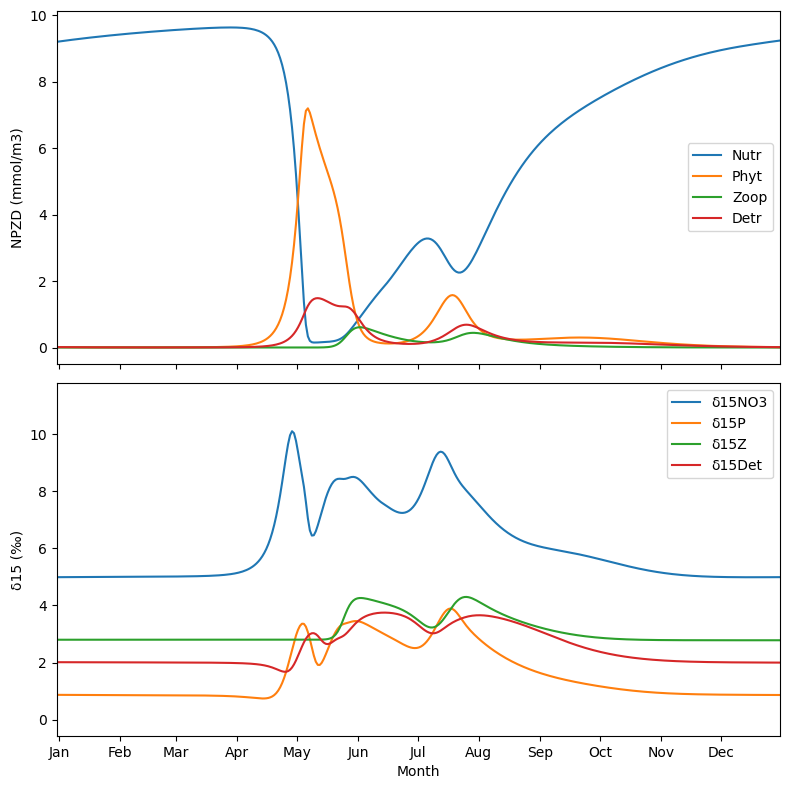

In [7]:
### Plot
# Extract output data
t_out = pd.to_datetime(out.t, unit = 'D',origin=pd.Timestamp("01-01-2020"))
N_out = out.y[0,:]
P_out = out.y[1,:]
Z_out = out.y[2,:]
D_out = out.y[3,:]
# Suplot
fig, [ax1,ax2]=plt.subplots(2,figsize=(8, 8),sharex=True)
# Plot NPZD
ax1.plot(t_out,N_out,label='Nutr')
ax1.plot(t_out,P_out,label='Phyt')
ax1.plot(t_out,Z_out,label='Zoop')
ax1.plot(t_out,D_out,label='Detr')
ax1.legend()
ax1.set_ylabel('NPZD (mmol/m3)')
# Plot d15
ax2.plot(t_out,delta15[0,:],label='δ15NO3')
ax2.plot(t_out,delta15[1,:],label='δ15P')
ax2.plot(t_out,delta15[2,:],label='δ15Z')
ax2.plot(t_out,delta15[3,:],label='δ15Det')
ax2.legend()
ax2.set_xlabel('Month')
ax2.set_ylabel('δ15 (‰)')
# Adjust x axis
xlim1 = pd.to_datetime(365*3, unit = 'D',origin=pd.Timestamp("01-01-2020"))
xlim2 = pd.to_datetime(365*4, unit = 'D',origin=pd.Timestamp("01-01-2020"))
ax2.set_xlim(xlim1,xlim2)
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

fig.tight_layout()
plt.show()

In [8]:
### Interactive model
%matplotlib inline
def mymodel(Vmax,K,Kp,Kammo,a,b,g,lp,lz,ld,KI,Nth,ammoth,zI,Wsink,c,fPAR,nit,h0,h1,I0,I1):
    # set time range
    trange = [0,365*10]
    # set parameters
    param=np.array([Vmax,K,Kp,Kammo,a,b,g,lp,lz,ld,KI,Nth,ammoth,zI,Wsink,c,fPAR,nit,h0,h1,I0,I1])
    # set initial conditions
    xinit = np.array([nuto,phyo,zooo,deto,1,1,1,1,1,1,1,1]) # inital 15N and 14N for all compartments is 1
    # time step size
    h = 1
    # Run model
    out = model_run(trange,xinit,param,h,NPZD)
    # Calculat d15N
    delta15 = (out.y[4:8,:]/out.y[8:12,:]-1)*1000
    # Extract output data
    t_out = pd.to_datetime(out.t, unit = 'D',origin=pd.Timestamp("01-01-2020"))
    N_out = out.y[0,:]
    P_out = out.y[1,:]
    Z_out = out.y[2,:]
    D_out = out.y[3,:]
    # Suplot
    fig, [ax1,ax2]=plt.subplots(2,figsize=(8, 8),sharex=True)
    fig.subplots_adjust(bottom=0.25)
    # Plot NPZD
    n=ax1.plot(t_out,N_out,label='Nutr')
    p=ax1.plot(t_out,P_out,label='Phyt')
    z=ax1.plot(t_out,Z_out,label='Zoop')
    d=ax1.plot(t_out,D_out,label='Detr')
    ax1.legend()
    ax1.set_ylabel('NPZD (mmol/m3)')
    # Plot d15
    ax2.plot(t_out,delta15[0,:],label='δ15NO3')
    ax2.plot(t_out,delta15[1,:],label='δ15P')
    ax2.plot(t_out,delta15[2,:],label='δ15Z')
    ax2.plot(t_out,delta15[3,:],label='δ15Det')
    ax2.legend()
    ax2.set_xlabel('Month')
    ax2.set_ylabel('δ15 (‰)')
    # Adjust x axis
    xlim1 = pd.to_datetime(365*3, unit = 'D',origin=pd.Timestamp("01-01-2020"))
    xlim2 = pd.to_datetime(365*4, unit = 'D',origin=pd.Timestamp("01-01-2020"))
    ax2.set_xlim(xlim1,xlim2)
    #ax1.set_ylim(0,10)
    #ax2.set_ylim(0,12)
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    fig.tight_layout()
    plt.show()

interact(mymodel,
         Vmax = FloatSlider(min=0, max=5, step =0.1, value=1),
         K =  FloatSlider(min=0, max=5, step =0.1, value=2),
         Kp = FloatSlider(min=0, max=5, step =0.1, value=2.8),
         Kammo =  FloatSlider(min=0, max=1, step =0.1, value=0.2),
         a =  FloatSlider(min=0, max=1, step =0.1, value=0.7),
         b = FloatSlider(min=0, max=1, step =0.1, value=0.5),
         g =  FloatSlider(min=0, max=5, step =0.1, value=1.4),
         lp = FloatSlider(min=0, max=0.2, step =0.01, value=0.05),
         lz = FloatSlider(min=0, max=0.2, step =0.01, value=0.05),
         ld=  FloatSlider(min=0, max=0.2, step =0.01, value=0.05),
         KI = FloatSlider(min=0, max=100, step =10, value=60),
         Nth =  FloatSlider(min=0, max=100, step =10, value=10),
         ammoth =  FloatSlider(min=0, max=50, step =1, value=3.5),
         zI = FloatSlider(min=0, max=100, step =10, value=20),
         Wsink = FloatSlider(min=0, max=100, step =10, value=10),
         c =  FloatSlider(min=0, max=0.1, step =0.01, value=0.005),
         fPAR = FloatSlider(min=0, max=1, step =0.1, value=0.4),
         nit = FloatSlider(min=0, max=1, step =0.05, value=0.15),
         h0 = FloatSlider(min=0, max=500, step =10, value=50),
         h1 = FloatSlider(min=0, max=500, step =10, value=100),
         I0 = FloatSlider(min=0, max=300, step =10, value=40),
         I1 = FloatSlider(min=0, max=300, step =10, value=150)
        );


interactive(children=(FloatSlider(value=1.0, description='Vmax', max=5.0), FloatSlider(value=2.0, description=…

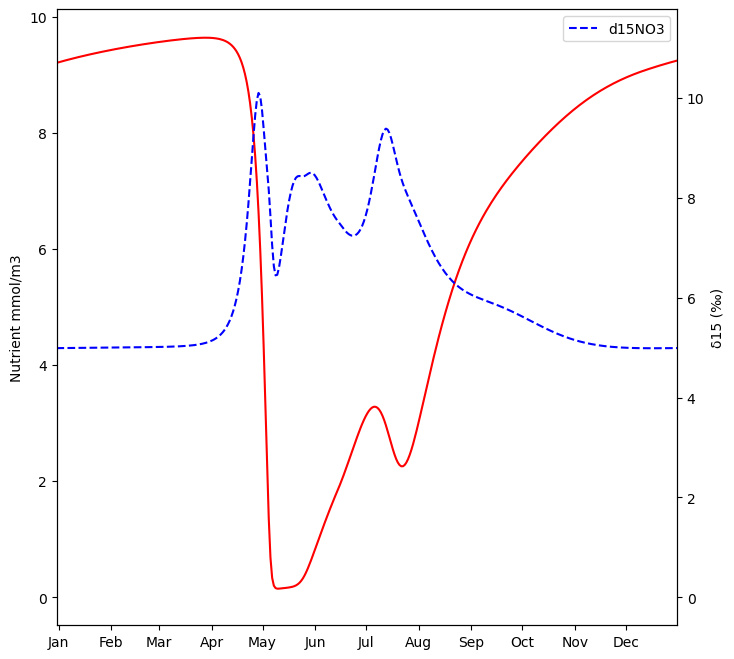

In [9]:
### [NO3] vs d15NO3
fig, ax1 = plt.subplots(figsize=(8, 8)) 
ax2 = ax1.twinx()
ax1.plot(t_out, N_out,color='r',label='NO3') 
ax2.plot(t_out, delta15[0,:],'b--',label='d15NO3')
ax1.set_ylabel('Nutrient mmol/m3')
ax2.set_ylabel('δ15 (‰)')
ax2.legend()
plt.xlim(xlim1,xlim2)
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

### NPZD-A2 model
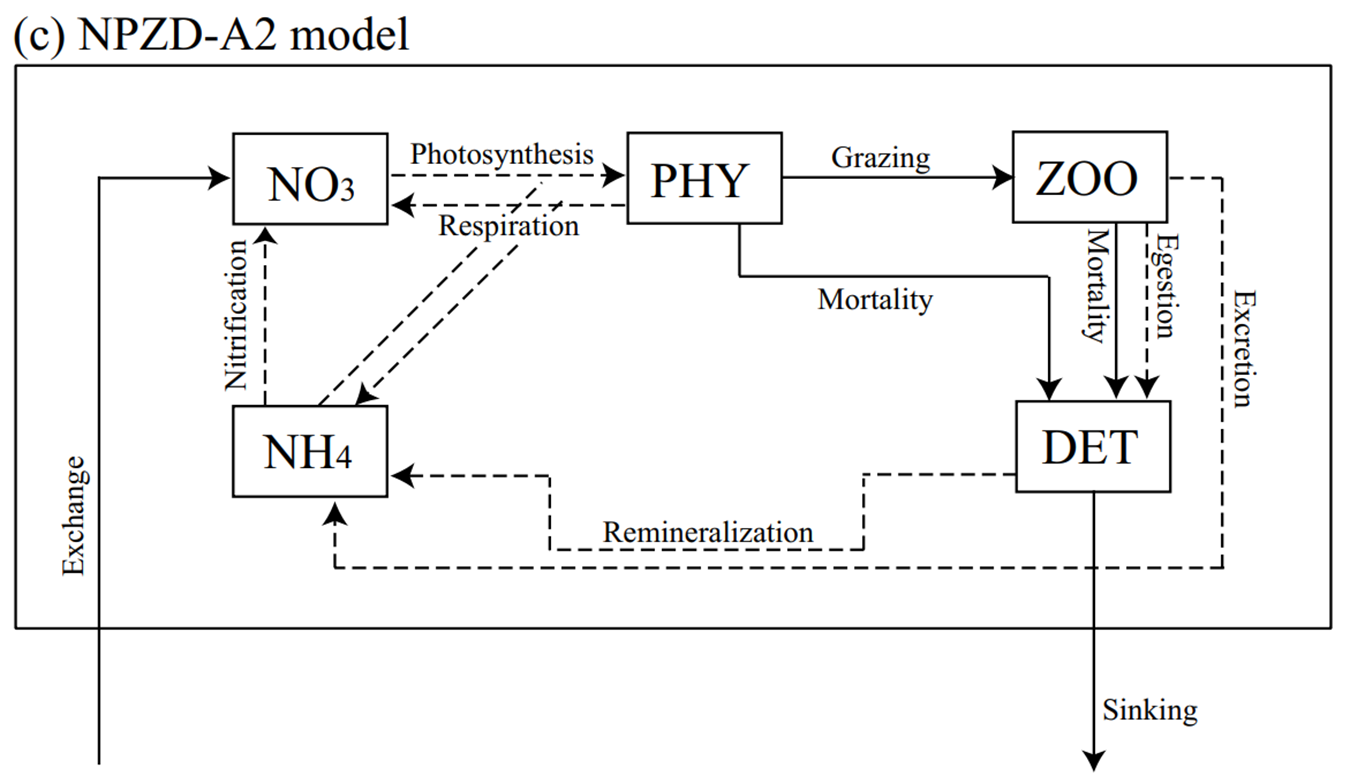

In [10]:
### NPZD-A2, model NO3 and NH4 separately
@jit
def NPZD_A2(t,x,Vmax,K,Kp,Kammo,a,b,g,lp,lz,ld,KI,Nth,ammoth,zI,Wsink,c,fPAR,nit,h0,h1,I0,I1):
    # Import initial conditions
    nitro, ammo, phy, zoo, det, N15, A15, P15, Z15, D15, N14, A14, P14, Z14, D14 = x
    # Simulated parameters
    hml = h0+h1*(1+np.cos(2*np.pi/360*t))
    dhdt= -h1*(2*np.pi/360)*np.sin(2*np.pi/360*t)
    ent0=dhdt/hml
    ent=np.where(ent0>0,ent0,0) + c
    I=fPAR*(I0+I1*(1-np.cos(2*np.pi/360*t)))
    Iave=I*zI/hml
    F=(nitro/(nitro+K))/(nitro/(nitro+K)+ammo/(ammo+Kammo))
    # NPZDA calculation
    dnitrodt = -Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI)*F -ent*(nitro-Nth) + nit*ammo 
    dammodt = -Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI)*(1-F) + ld*det + (a-b)*zoo*g*phy/Kp -ent*(ammo-ammoth) - nit*ammo
    dphydt = Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI) - zoo*g*phy/Kp - (lp+ent)*phy
    dzoodt = zoo*g*phy/Kp - (lz+ent)*zoo - (a-b)*zoo*g*phy/Kp - (1-a)*zoo*g*phy/Kp
    ddetdt = (1-a)*zoo*g*phy/Kp + lz*zoo + lp*phy - (ld+ent)*det -Wsink/hml*det
    # 15N calculation
    d15nitrodt = -Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI)*F*N15*alpha(eps_uptakeN) - ent*(nitro*N15-Nth*Nth15) + nit*ammo*A15*alpha(eps_nitri)
    d15ammodt = -Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI)*(1-F)*A15*alpha(eps_uptakeA) + ld*det*D15*alpha(eps_reminer) + (a-b)*zoo*g*phy/Kp*Z15*alpha(eps_excretion) - ent*(ammo*A15-ammoth*ammoth15) - nit*ammo*A15*alpha(eps_nitri)
    d15phydt = Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI)*F*N15*alpha(eps_uptakeN) + Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI)*(1-F)*A15*alpha(eps_uptakeA) - zoo*g*phy/Kp*P15 - (lp+ent)*phy*P15
    d15zoodt = zoo*g*phy/Kp*P15 - (lz+ent)*zoo*Z15 - (a-b)*zoo*g*phy/Kp*Z15*alpha(eps_excretion) - (1-a)*zoo*g*phy/Kp*Z15*alpha(eps_egestion)
    d15detdt = (1-a)*zoo*g*phy/Kp*Z15*alpha(eps_egestion) + lz*zoo*Z15 + lp*phy*P15 - ld*det*D15*alpha(eps_reminer) -ent*det*D15 -Wsink/hml*det*D15
    # 14N calculation
    d14nitrodt = -Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI)*F*N14 - ent*(nitro*N14-Nth*Nth14) + nit*ammo*A14
    d14ammodt = -Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI)*(1-F)*A14 + ld*det*D14*alpha(eps_reminer) + (a-b)*zoo*g*phy/Kp*Z14  - ent*(ammo*A14-ammoth*ammoth14) - nit*ammo*A14
    d14phydt = Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI)*F*N14 + Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI)*(1-F)*A14 - zoo*g*phy/Kp*P14 - (lp+ent)*phy*P14
    d14zoodt = zoo*g*phy/Kp*P14 - (lz+ent)*zoo*Z14 - (a-b)*zoo*g*phy/Kp*Z14 - (1-a)*zoo*g*phy/Kp*Z14
    d14detdt = (1-a)*zoo*g*phy/Kp*Z14 + lz*zoo*Z14 + lp*phy*P14 - ld*det*D14 -ent*det*D14 -Wsink/hml*det*D14
    # Export
    out=np.array([dnitrodt,dammodt,dphydt,dzoodt,ddetdt,d15nitrodt,d15ammodt,d15phydt,d15zoodt,d15detdt,d14nitrodt,d14ammodt,d14phydt,d14zoodt,d14detdt])
    return out


In [11]:
### Run model
Nth=10
ammoth=3.5
# set time range
trange = [0,365*5]
# set parameters
param=np.array([Vmax,K,Kp,Kammo,a,b,g,lp,lz,ld,KI,Nth,ammoth,zI,Wsink,c,fPAR,nit,h0,h1,I0,I1])
# set initial conditions
xinit = np.array([nuto,.001,phyo,zooo,deto,1,1,1,1,1,1,1,1,1,1])
# time step size
h = 1
# Run model
a2out = model_run(trange,xinit,param,h,NPZD_A2)
# Calculat d15N
delta15 = (a2out.y[5:10,:]/a2out.y[10:15,:]-1)*1000

/tmp/ipykernel_133/2178693307.py:3: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "model_run" failed type inference due to: Untyped global name 'solve_ivp': Cannot determine Numba type of <class 'function'>

File "../../../../../../tmp/ipykernel_133/2178693307.py", line 6:
<source missing, REPL/exec in use?>

  @jit
/home/anhph/anaconda3/envs/ecosystem/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "model_run" was compiled in object mode without forceobj=True.

File "../../../../../../tmp/ipykernel_133/2178693307.py", line 3:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/anhph/anaconda3/envs/ecosystem/lib/python3.10/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit 

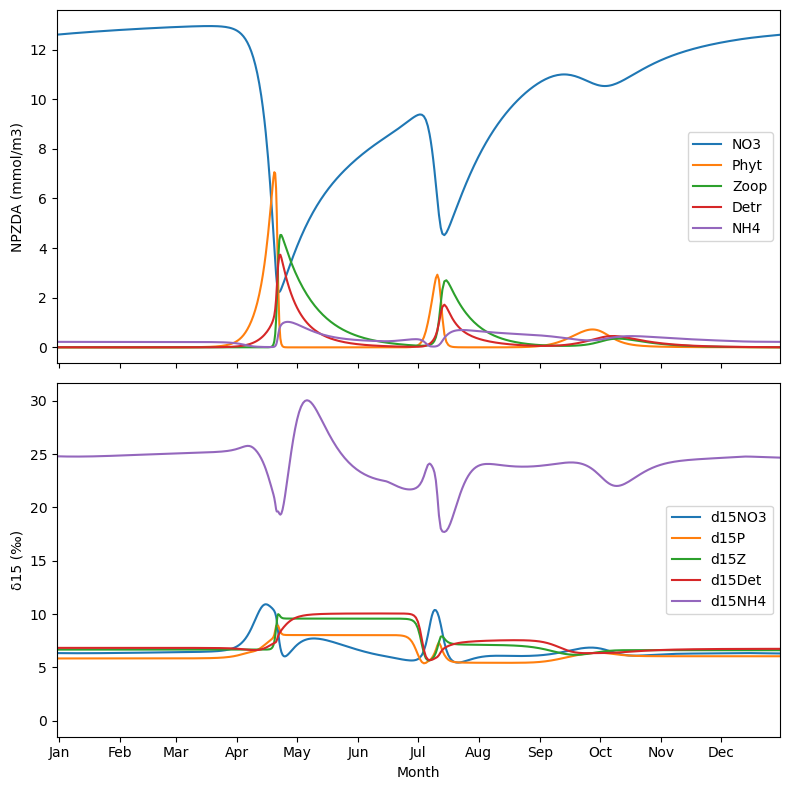

In [12]:
### Plot
# plot the N15put
t_a2out = pd.to_datetime(a2out.t, unit = 'D',origin=pd.Timestamp("01-01-2020"))
N_a2out = a2out.y[0,:]
A_a2out = a2out.y[1,:]
P_a2out = a2out.y[2,:]
Z_a2out = a2out.y[3,:]
D_a2out = a2out.y[4,:]
#
fig, [ax1,ax2]=plt.subplots(2,figsize=(8, 8),sharex=True)
# Plot NPZDA
ax1.plot(t_a2out,N_a2out,label='NO3')
ax1.plot(t_a2out,P_a2out,label='Phyt')
ax1.plot(t_a2out,Z_a2out,label='Zoop')
ax1.plot(t_a2out,D_a2out,label='Detr')
ax1.plot(t_a2out,A_a2out,label='NH4')
ax1.legend()
ax1.set_ylabel('NPZDA (mmol/m3)')
# Plot d15
ax2.plot(t_a2out,delta15[0,:],label='d15NO3')
ax2.plot(t_a2out,delta15[2,:],label='d15P')
ax2.plot(t_a2out,delta15[3,:],label='d15Z')
ax2.plot(t_a2out,delta15[4,:],label='d15Det')
ax2.plot(t_a2out,delta15[1,:],label='d15NH4')
ax2.legend()
ax2.set_xlabel('Month')
ax2.set_ylabel('δ15 (‰)')
# Adjust x axis
xlim1 = pd.to_datetime(365*3, unit = 'D',origin=pd.Timestamp("01-01-2020"))
xlim2 = pd.to_datetime(365*4, unit = 'D',origin=pd.Timestamp("01-01-2020"))
ax2.set_xlim(xlim1,xlim2)
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
fig.tight_layout()
plt.show()

In [13]:
### Interactive model
%matplotlib inline
def mymodel(Vmax,K,Kp,Kammo,a,b,g,lp,lz,ld,KI,Nth,ammoth,zI,Wsink,c,fPAR,nit,h0,h1,I0,I1):
    # set time range
    trange = [0,365*5]
    # set parameters
    param=np.array([Vmax,K,Kp,Kammo,a,b,g,lp,lz,ld,KI,Nth,ammoth,zI,Wsink,c,fPAR,nit,h0,h1,I0,I1])
    # set initial conditions
    xinit = np.array([nuto,.001,phyo,zooo,deto,1,1,1,1,1,1,1,1,1,1])
    # time step size
    h = 1
    # Run model
    a2out = model_run(trange,xinit,param,h,NPZD_A2)
    # Calculat d15N
    delta15 = (a2out.y[5:10,:]/a2out.y[10:15,:]-1)*1000
    
    # plot the N15put
    t_a2out = pd.to_datetime(a2out.t, unit = 'D',origin=pd.Timestamp("01-01-2020"))
    N_a2out = a2out.y[0,:]
    A_a2out = a2out.y[1,:]
    P_a2out = a2out.y[2,:]
    Z_a2out = a2out.y[3,:]
    D_a2out = a2out.y[4,:]
    #
    fig, [ax1,ax2]=plt.subplots(2,figsize=(8, 8),sharex=True)
    # Plot NPZDA
    ax1.plot(t_a2out,N_a2out,label='NO3')
    ax1.plot(t_a2out,P_a2out,label='Phyt')
    ax1.plot(t_a2out,Z_a2out,label='Zoop')
    ax1.plot(t_a2out,D_a2out,label='Detr')
    ax1.plot(t_a2out,A_a2out,label='NH4')
    ax1.legend()
    ax1.set_ylabel('NPZDA (mmol/m3)')
    # Plot d15
    ax2.plot(t_a2out,delta15[0,:],label='d15NO3')
    ax2.plot(t_a2out,delta15[2,:],label='d15P')
    ax2.plot(t_a2out,delta15[3,:],label='d15Z')
    ax2.plot(t_a2out,delta15[4,:],label='d15Det')
    ax2.plot(t_a2out,delta15[1,:],label='d15NH4')
    ax2.legend()
    ax2.set_xlabel('Month')
    ax2.set_ylabel('δ15 (‰)')
    # Adjust x axis
    xlim1 = pd.to_datetime(365*3, unit = 'D',origin=pd.Timestamp("01-01-2020"))
    xlim2 = pd.to_datetime(365*4, unit = 'D',origin=pd.Timestamp("01-01-2020"))
    ax2.set_xlim(xlim1,xlim2)
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    fig.tight_layout()
    plt.show()

interact(mymodel,
         Vmax = FloatSlider(min=0, max=5, step =0.1, value=1),
         K =  FloatSlider(min=0, max=5, step =0.1, value=2),
         Kp = FloatSlider(min=0, max=5, step =0.1, value=2.8),
         Kammo =  FloatSlider(min=0, max=1, step =0.1, value=0.2),
         a =  FloatSlider(min=0, max=1, step =0.1, value=0.7),
         b = FloatSlider(min=0, max=1, step =0.1, value=0.5),
         g =  FloatSlider(min=0, max=5, step =0.1, value=1.4),
         lp = FloatSlider(min=0, max=0.2, step =0.01, value=0.05),
         lz = FloatSlider(min=0, max=0.2, step =0.01, value=0.05),
         ld=  FloatSlider(min=0, max=0.2, step =0.01, value=0.05),
         KI = FloatSlider(min=0, max=100, step =10, value=60),
         Nth =  FloatSlider(min=0, max=100, step =10, value=10),
         ammoth =  FloatSlider(min=0, max=50, step =1, value=3.5),
         zI = FloatSlider(min=0, max=100, step =10, value=20),
         Wsink = FloatSlider(min=0, max=100, step =10, value=10),
         c =  FloatSlider(min=0, max=0.1, step =0.01, value=0.005),
         fPAR = FloatSlider(min=0, max=1, step =0.1, value=0.4),
         nit = FloatSlider(min=0, max=1, step =0.05, value=0.15),
         h0 = FloatSlider(min=0, max=500, step =10, value=50),
         h1 = FloatSlider(min=0, max=500, step =10, value=100),
         I0 = FloatSlider(min=0, max=300, step =10, value=40),
         I1 = FloatSlider(min=0, max=300, step =10, value=150)
        );


interactive(children=(FloatSlider(value=1.0, description='Vmax', max=5.0), FloatSlider(value=2.0, description=…

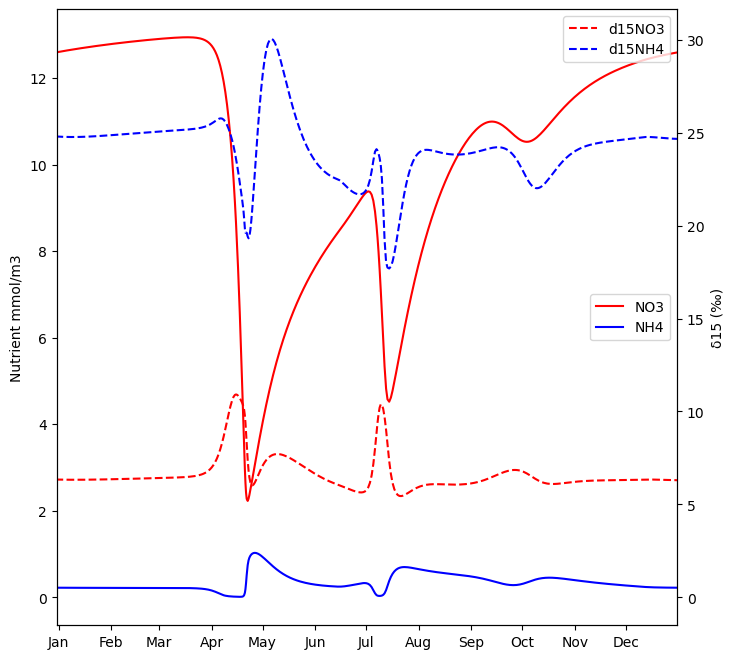

In [14]:
### Concentration vs d15
fig, ax1 = plt.subplots(figsize=(8, 8)) 
ax2 = ax1.twinx()
ax1.plot(t_a2out, N_a2out,color='r',label='NO3') 
ax1.plot(t_a2out, A_a2out,color='b',label='NH4')
ax2.plot(t_a2out, delta15[0,:],'r--',label='d15NO3')
ax2.plot(t_a2out, delta15[1,:],'b--',label='d15NH4')
ax1.set_ylabel('Nutrient mmol/m3')
ax2.set_ylabel('δ15 (‰)')
ax1.legend()
ax2.legend()
plt.xlim(xlim1,xlim2)
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
